## CellMincer segmentation

The loss function is:

$$
\begin{align}
\mathcal{L} = & \, \frac{1}{A}\sum_p\log\,\sigma_p + \frac{1}{A\,T}\sum_{t,p} \frac{1}{2\sigma_p^2}\left|M_{tp} - \textstyle{\sum_{\mu=1}^{M}}  \, \tau_{t \mu}\, \omega_{\mu p} \right|^2 \qquad \text{(Gaussian noise)} \\
& + \frac{1}{2 T}\sum_{t,\mu} \tau_{t \mu}^2 \qquad \text{(Normal prior to set the scale of $\tau_{t\mu}$)} \\
& + \frac{1}{A}\sum_p \frac{\sigma_p}{\bar{\sigma}} \qquad \text{(Exponential prior for per-pixel variance)} \\
& + \mathcal{L}_\mathrm{loc} + \mathcal{L}_\mathrm{ARD} \qquad \text{(Regularization)}.
\end{align}
$$

Here, $p$, $\mu$, and $t$ correspond to pixels, objects (neurons), and time, respectively. $\omega_{\mu p} \geq 0$ is the per-pixel foreground contribution of each neuron, and $\tau_{\mu t}$ is the temporal trace of each neuron.

**Locality regularization**: The _weight localization score_, $L_\mu \in [0, 1]$, is defined as:

$$L_\mu = \frac{\max_p\, \sum_{p'} k_{p,p'} \, \omega_{\mu p'}}{\sum_{p'} \omega_{\mu p'}},$$

where $k_{p,p'} = \theta[r^* - |\mathbf{r}_p - \mathbf{r}_{p'}|]$ is a circular kernel with radius $r^*$. Calculating $\gamma_\mu[\omega_{\mu p}]$ involves finding a circular region of radius $r^*$ that contains most of the weight and can be done quickly using 2D convolutions. The regularizartion is:

$$\mathcal{L}_\mathrm{loc} = \lambda_\mathrm{loc} \, \sum_{\mu=1}^{M} \, (1 - L_\mu)$$


**Parsimony regularization**: We would like to explain the movie with as few neurons as possible. We assume $\omega_{\mu p} \sim \mathrm{Exp}(\lambda_\mu)$ and allow optimization of $\lambda_\mu$. Neurons that explain significant variance will have relatively large $\omega_{\mu p}$ and as such, the prior is optimized for a finite $\lambda_\mu$. On the other hand, neurons that explain small variance can decrease the loss function by taking the opposite limit, i.e. $\omega_{\mu p} \rightarrow 0$ and $\lambda_\mu \rightarrow \infty$. The regularization is:

$$\mathcal{L}_\mathrm{ARD} = \lambda_\mathrm{ARD}\sum_\mu \left(-\log \lambda_\mu + \frac{\lambda_\mu}{A}\sum_p \omega_{\mu p}\right).$$


**Marginalization of $\tau_{t\mu}$**: we can marginalize $\tau_{t\mu}$ exactly. The result is:

$$\boldsymbol{\tau}^T = \left(\mathbb{I}_{M} + \boldsymbol{\omega} \, \boldsymbol{\Lambda} \, \boldsymbol{\omega}^T\right)^{-1} \, \boldsymbol{\omega} \, \boldsymbol{\Lambda} \, \mathbf{M}^T,$$

where $\boldsymbol{\Lambda} = \mathrm{diag}\{\sigma_1^{-2}, \sigma_2^{-2}, \ldots\}$ is the diagonal precision matrix.


<!-- **Initialization**: TBW.

Finally, $\omega_{\mu p}$ is calculated as follows. We define:

$$\chi_{\mu p} \equiv \frac{\frac{1}{T}\sum_{t=1}^{T}\left(M_{tp} - \bar{M}_{tp}\right)\left(\tau_{\mu t} - \bar{\tau}_{\mu t}\right)}{\sigma(M_{tp} - \bar{M}_{tp}) \, \sigma(\tau_{\mu t} - \bar{\tau}_{\mu t})},$$

where $\bar{M}_{tp}$ and $\bar{\tau}_{\mu t}$ denote the movie and trace trends, respectively (calculated via moving average or median filtering). Intuitively, $\chi_{\mu p} \in [-1, 1]$ is positive and large for pixels that temporally correlated with $\tau_{\mu t}$. We feed $\chi_{\mu p}$ to a U-Net conditioned on global features $\mathfrak{F}$, and expected a probability map $\tilde{\omega}_{\mu p} \in [0, 1]$ in the output. The latter denotes the responsibility of each pixel for trace element $\mu$. Finally, we lift the single-trace probability maps to a simplex:

$$\omega_{\mu p} \equiv \frac{\tilde{\omega}_{\mu p}}{\sum_\mu \tilde{\omega}_{\mu p}}$$.

The global per-pixel responsibility $\alpha_p$ is calculated from $\mathfrak{F}$ via a dedicated U-Net. $\{\alpha_\mu\}$ are variational parameters. The training involves a E-step and an M-step. In the E-step, $\tau_{\mu t}$ are help fixed and everything else is optimized. In the M-step, everything is fixed save for $\tau_{\mu t}$. We perform inexact E- and M-step updates via SGD. We initiatize $\tau_{\mu t}$ to a uniform subsampling of foreground pixels. -->

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import torch
import logging
import pickle

from skimage.filters import threshold_otsu

from cellmincer.opto_ws import \
    OptopatchBaseWorkspace, \
    OptopatchGlobalFeaturesTorchCache

from cellmincer.opto_features import \
    OptopatchGlobalFeatureExtractor, \
    OptopatchGlobalFeatureContainer

from cellmincer.opto_denoise import \
    get_unet_input_size

from cellmincer.opto_models import \
    ConditionalUNet, \
    center_crop_2d, \
    activation_from_str

from cellmincer.opto_utils import \
    crop_center

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()
log_info = logger.warning

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [2]:
# list of Optopatch movies
model_prefix = 'final_nopad_l2'

denoised_opto_mov_path_list = [
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV2_W2_at171603__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D4_FOV3_W2_at172029__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/E3_FOV1_W2_at155440__{model_prefix}__denoised.npy',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/F1_FOV2_W1_at143005__{model_prefix}__denoised.npy',
]

denoised_opto_feature_path_list = [
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D1_FOV3_W2_at135105__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D4_FOV2_W2_at171603__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/D4_FOV3_W2_at172029__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/E3_FOV1_W2_at155440__features.pkl',
    f'/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_feature_data/F1_FOV2_W1_at143005__features.pkl',
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'
feature_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/feature_data'
model_root = '/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models_new'

if not os.path.exists(feature_path):
    os.mkdir(feature_path)

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

In [3]:
i_dataset = 0
ws_base = OptopatchBaseWorkspace.from_npy(denoised_opto_mov_path_list[i_dataset])
with open(denoised_opto_feature_path_list[i_dataset], 'rb') as f:
    feature_container = pickle.Unpickler(f).load()

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data/D1_FOV3_W2_at135105__final_nopad_l2__denoised.npy ...


In [4]:
active_mask_t = OptopatchGlobalFeatureExtractor.determine_active_t_range(
    ws_base=ws_base,
    select_active_t_range=False)

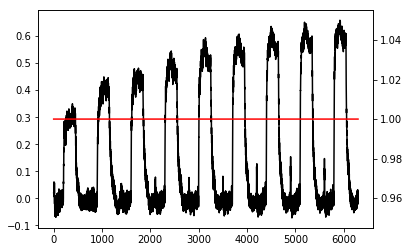

In [5]:
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(np.mean(ws_base.movie_txy, axis=(-1, -2)), color='black')
ax2.plot(active_mask_t, color='red')

In [6]:
ws_base = ws_base.get_t_truncated_movie(np.where(active_mask_t)[0])

In [7]:
viz_pix_list = [
    (20, 62),
    (125, 80),
    (165, 150),
    (200, 150),
    (180, 120),
    (395, 135),
    (400, 150),
]

## Implementation

In [158]:
from boltons.cacheutils import cachedproperty


def get_detrended_movie_torch(
        movie_ntxy: np.ndarray,
        detrending_order: int,
        detrending_func: str,
        device: torch.device,
        dtype: torch.dtype) -> torch.Tensor:
    assert detrending_order > 0
    assert detrending_func in {'mean', 'median'}
    
    # reflection pad in time
    padded_movie_ntxy = torch.tensor(
        np.pad(
            array=movie_ntxy,
            pad_width=((0, 0), (detrending_order, detrending_order), (0, 0), (0, 0)),
            mode='reflect'),
        device=device,
        dtype=dtype)
    
    detrended_movie_ntxy = torch.zeros(
        movie_ntxy.shape,
        device=device,
        dtype=dtype)

    # calculate temporal moving average
    if detrending_func == 'mean':
        for i_t in range(movie_ntxy.shape[-3]):
            detrended_movie_ntxy[:, i_t, :, :] = padded_movie_ntxy[:, i_t + detrending_order, :, :] - torch.mean(
                padded_movie_ntxy[:, i_t:(i_t + 2 * detrending_order + 1), :, :],
                dim=-3)
    elif detrending_func == 'median':
        for i_t in range(movie_ntxy.shape[-3]):
            detrended_movie_ntxy[:, i_t, :, :] = padded_movie_ntxy[:, i_t + detrending_order, :, :] - torch.median(
                padded_movie_ntxy[:, i_t:(i_t + 2 * detrending_order + 1), :, :],
                dim=-3)[0]
    else:
        raise ValueError()

    return detrended_movie_ntxy


def get_detrended_tau_mt(
        tau_mt: torch.Tensor,
        detrending_order: int,
        detrending_func: str,
        device: torch.device,
        dtype: torch.dtype) -> torch.Tensor:
    assert detrending_order > 0
    assert detrending_func in {'mean'}
    
    # reflection pad in time
    padded_tau_m1t = torch.nn.ReflectionPad1d(detrending_order)(
        tau_mt[:, None, :])
    
    # trend
    moving_average_kern = torch.ones(
        (1, 1, 2 * detrending_order + 1),
        device=device,
        dtype=dtype) / (2 * detrending_order + 1)
    padded_tau_trend_m1t = torch.nn.functional.conv1d(
        padded_tau_m1t, moving_average_kern)
    return tau_mt - padded_tau_trend_m1t[:, 0, ]



class OptopatchSegmentationWorkspace:
    def __init__(
            self,
            ws_base: OptopatchBaseWorkspace,
            features: OptopatchGlobalFeatureContainer,
            segmenter_config: dict,
            eps: float,
            device: torch.device,
            dtype: torch.dtype):
        self.ws_base = ws_base
        self.features = features
        self.segmenter_config = segmenter_config
        self.eps = eps
        
        self.device = device
        self.dtype = dtype
        
        # pad and cache the features
        self.cached_features = OptopatchGlobalFeaturesTorchCache(
            features=features,
            x_padding=0,
            y_padding=0,
            device=device,
            dtype=dtype)
        
        # scale the movie and flatten in xy
        if segmenter_config['detrend_movie'] == True:
            
            self.movie_tp = get_detrended_movie_torch(
                movie_ntxy=ws_base.movie_txy[None, ...] / features.norm_scale,
                detrending_order=segmenter_config['detrending_order'],
                detrending_func=segmenter_config['detrending_func'],
                device=device,
                dtype=dtype).view(ws_base.n_frames, -1).contiguous()
            
        else:
            
            self.movie_tp = torch.tensor(
                ws_base.movie_txy / features.norm_scale,
                device=device,
                dtype=dtype).view(ws_base.n_frames, -1).contiguous()
        
        # # subtract mean
        # self.movie_tp -= torch.mean(self.movie_tp, dim=0, keepdim=True)

        self.n_frames = self.movie_tp.shape[0]
        self.n_pixels = self.movie_tp.shape[1]
        self.n_masks = segmenter_config['grid_size_x'] * segmenter_config['grid_size_y']

        # hyperparameters
        self.detrending_order = segmenter_config['detrending_order']
        self.sigma_bar = segmenter_config['sigma_bar']
        self.ard_reg_strength = segmenter_config['ard_reg_strength']
        self.loc_reg_strength = segmenter_config['loc_reg_strength']
        self.overlap_reg_strength = segmenter_config['overlap_reg_strength']
        self.neg_tau_reg_strength = segmenter_config['neg_tau_reg_strength']
        self.ortho_tau_reg_strength = segmenter_config['ortho_tau_reg_strength']
        self.init_lambda_ard = segmenter_config['init_lambda_ard']
        self.loc_radius = segmenter_config['loc_radius']
        self.loc_stride = segmenter_config['loc_stride']
        self.loc_repeat = segmenter_config['loc_repeat']
        
        # masks
        self.log_omega_mp = torch.nn.Parameter(
            torch.tensor(
                self.generate_init_log_weights_mxy(),
                device=device,
                dtype=dtype).view(self.n_masks, -1).contiguous().clone())

        # unexplained variance
        self.log_sigma_p = torch.nn.Parameter(
            np.log(segmenter_config['init_sigma']) * torch.ones(
                self.n_pixels,
                device=device,
                dtype=dtype))
        
        # ARD coefficients
        self.log_lambda_ard_m = torch.nn.Parameter(
            np.log(self.init_lambda_ard) * torch.ones(
                self.n_masks, device=device, dtype=dtype))
        
        # auxiliary
        self.eye_mm = torch.eye(self.n_masks, device=device, dtype=dtype)

    @property
    def parameters(self):
        return [
            self.log_omega_mp,
            self.log_sigma_p,
            self.log_lambda_ard_m]

    def generate_init_log_weights_mxy(self):
        # generate the initial masks
        trend_std_xy = crop_center(
            self.cached_features.features_1fxy[
                0, self.cached_features.feature_name_list.index('trend_std_0'), :, :],
            target_width=self.ws_base.width,
            target_height=self.ws_base.height).cpu().numpy()

        init_log_weight_1xy_list = []
        grid_center_x = [
            int((2 * i_x + 1) * self.ws_base.width / (2 * self.segmenter_config['grid_size_x']))
            for i_x in range(self.segmenter_config['grid_size_x'])]
        grid_center_y = [
            int((2 * i_y + 1) * self.ws_base.height / (2 * self.segmenter_config['grid_size_y']))
            for i_y in range(self.segmenter_config['grid_size_y'])]

        for x0 in grid_center_x:
            for y0 in grid_center_y:
                x = np.arange(0, self.ws_base.width)[:, None]
                y = np.arange(0, self.ws_base.height)[None, :]
                log_gaussian_mask_xy = -((x - x0)**2 + (y - y0)**2) / (
                    2 * self.segmenter_config['init_mask_radius']**2)
                init_log_weight_xy = log_gaussian_mask_xy + np.log(trend_std_xy).mean()
                init_log_weight_1xy_list.append(init_log_weight_xy[None, :, :])
                
        return np.concatenate(init_log_weight_1xy_list, axis=0)

    def get_weight_localization_score(
            self,
            weight_mp: torch.Tensor,
            radius: int,
            repeat: int,
            stride: int,
            eps: float = 1e-6):

        # circular structure
        n_batch, n_pixels = weight_mp.shape
        x = torch.arange(
            - radius * repeat,
            radius * repeat + 1,
            dtype=self.dtype,
            device=self.device)[None, :]
        y = torch.arange(
            - radius * repeat,
            radius * repeat + 1,
            dtype=self.dtype,
            device=self.device)[:, None]
        struct = torch.exp(- ((x.pow(2) + y.pow(2)) / (2 * radius ** 2)))
        struct = struct / struct.sum()
        kern = struct[None, None, ...]

        # calculate locally-summed weight
        locally_summed_weight_map_mxy = torch.nn.functional.conv2d(
            weight_mp.view(
                n_batch,
                1,
                self.ws_base.width,
                self.ws_base.height),
            kern,
            stride=stride,
            padding=radius * repeat)[:, 0, :, :]

        # total weight
        total_weight_m = torch.sum(weight_mp, dim=-1) / self.n_pixels

        # largest locally summed weight
        max_weight_m, _ = torch.max(locally_summed_weight_map_mxy.view(n_batch, -1), dim=-1)

        return max_weight_m / (total_weight_m + eps)
    
    
    def get_tau_mt(self, t_index_tensor: torch.Tensor):
        c_n_frames = t_index_tensor.numel()
        movie_tp = self.movie_tp[t_index_tensor, :]
        
        # auxiliary variables
        omega_mp = self.log_omega_mp.exp()
        # log_sigma_p = self.log_sigma_scalar.expand([self.n_pixels])
        log_sigma_p = self.log_sigma_p
        sigma_p = log_sigma_p.exp()
        prec_p = sigma_p.pow(2).reciprocal()

        # reconstruction loss
        with torch.no_grad():
            v_mt = torch.einsum(
                'mp,p,tp->mt',
                omega_mp, prec_p, movie_tp)
            q_mm = self.eye_mm + torch.einsum(
                'mp,p,np->mn',
                omega_mp, prec_p, omega_mp)
            l_mm = torch.cholesky(q_mm)
            tau_mt = v_mt.cholesky_solve(l_mm, upper=False)
            
        return tau_mt

    def get_tau_marginalized_loss(self, t_index_tensor: torch.Tensor):
        if t_index_tensor is None:
            c_n_frames = self.n_frames
            movie_tp = self.movie_tp
        else:
            c_n_frames = t_index_tensor.numel()
            movie_tp = self.movie_tp[t_index_tensor, :]
        
        # scale factor to compensate for temporal minibatching
        t_scale_factor = self.n_frames / c_n_frames
        loss_scale = self.n_pixels * self.n_frames

        # auxiliary variables
        omega_mp = self.log_omega_mp.exp()
        # log_sigma_p = self.log_sigma_scalar.expand([self.n_pixels])
        log_sigma_p = self.log_sigma_p
        sigma_p = log_sigma_p.exp()
        prec_p = sigma_p.pow(2).reciprocal()
        lambda_ard_m = self.log_lambda_ard_m.exp()

        # tau-marginalized reconstruction loss
        b_mt = torch.einsum(
            'mp,p,tp->mt',
            omega_mp, prec_p, movie_tp)
        overlap_mm = torch.einsum(
            'mp,p,np->mn',
            omega_mp, prec_p, omega_mp)
        q_mm = self.eye_mm + overlap_mm
        l_mm = torch.cholesky(q_mm)
        tau_mt = b_mt.cholesky_solve(l_mm, upper=False)

        rec_loss_log_sigma = log_sigma_p.sum() * c_n_frames
        rec_loss_log_det_q = + 0.5 * torch.logdet(q_mm) * c_n_frames
        rec_loss_linear_term = - 0.5 * (b_mt * tau_mt).sum()
        rec_loss_cov_term = 0.5 * (movie_tp.pow(2) * prec_p).sum()
        rec_loss = t_scale_factor * (rec_loss_log_sigma
                    + rec_loss_log_det_q
                    + rec_loss_linear_term
                    + rec_loss_cov_term)
        
        # unexplained variance prior
        sigma_loss = sigma_p.sum() / self.sigma_bar + self.n_pixels * np.log(self.sigma_bar)
        
        # ARD prior
        ard_loss = self.ard_reg_strength * (
            0.5 * (omega_mp.pow(2).sum(-1) * lambda_ard_m).sum()
            - 0.5 * self.n_pixels * self.log_lambda_ard_m.sum())

        # localization regularization
        loc_m = self.get_weight_localization_score(
            weight_mp=omega_mp,
            radius=self.loc_radius,
            stride=self.loc_stride,
            repeat=self.loc_repeat)
        loc_loss = - loss_scale * self.loc_reg_strength * loc_m.sum()
        
        # overlap-avoidance regularization
        omega_norm_m = omega_mp.pow(2).sum(-1).sqrt()
        omega_overlap_mm = overlap_mm.clone()
        omega_overlap_mm.fill_diagonal_(0.)
        overlap_loss = self.n_frames * self.overlap_reg_strength * omega_overlap_mm.sum()
        
#         # negative-tau-avoidance regularization
#         neg_tau_loss = self.neg_tau_reg_strength * torch.clamp(- tau_mt, min=0).pow(4).sum()
        
        # tau-orthogonality regularization
        detrended_tau_mt = get_detrended_tau_mt(
            tau_mt=tau_mt,
            detrending_order=self.detrending_order,
            detrending_func='mean',
            device=self.device,
            dtype=self.dtype)
        detrended_tau_mt = detrended_tau_mt - detrended_tau_mt.mean(-1)[:, None]
        detrended_tau_cross_mm = torch.mm(detrended_tau_mt, detrended_tau_mt.t()) / c_n_frames
        detrended_tau_std_m = torch.diag(detrended_tau_cross_mm).sqrt()
        detrended_tau_cross_mm.fill_diagonal_(0.)
        detrended_tau_cross_mm = detrended_tau_cross_mm / torch.ger(
            detrended_tau_std_m, detrended_tau_std_m)
        ortho_tau_reg_loss = loss_scale * self.ortho_tau_reg_strength * detrended_tau_cross_mm.abs().sum()
        
        return {
            'rec_loss': rec_loss,
            'sigma_loss': sigma_loss,
            'ard_loss': ard_loss,
            'loc_loss': loc_loss,
#             'neg_tau_loss': neg_tau_loss,
            'ortho_tau_reg_loss': ortho_tau_reg_loss,
            'overlap_loss': overlap_loss,
        }

## Initialization

In [159]:
segmenter_config = {
    'grid_size_x': 15,
    'grid_size_y': 5,
    'init_mask_radius': 20,
    'sigma_bar': 0.001,
    'init_sigma': 0.1,
    't_batch_size': None,
    'loc_radius': 50,
    'loc_stride': 5,
    'loc_repeat': 3,
    'ard_reg_strength': 1.0,
    'loc_reg_strength': 1e-2,
    'overlap_reg_strength': 1.0,
    'neg_tau_reg_strength': 1e+3,
    'ortho_tau_reg_strength': 1e-2,
    'init_lambda_ard': 1e2,
    'detrend_movie': True,
    'detrending_order': 5,
    'detrending_func': 'median'
}

In [160]:
ws_seg = OptopatchSegmentationWorkspace(
    ws_base=ws_base,
    features=feature_container,
    segmenter_config=segmenter_config,
    eps=1e-6,
    device=device,
    dtype=dtype)

In [161]:
all_params = ws_seg.parameters
optim = torch.optim.Adam(all_params, lr=1e-2, betas=(0.9, 0.999))
# optim = torch.optim.LBFGS(all_params, lr=0.1, history_size=10)

In [162]:
n_iters = 10000
log_every = 20

loss_hist_dict = None

In [163]:
i_iter = 0

In [187]:
torch.cuda.empty_cache()

loss_scale = ws_seg.n_pixels * ws_seg.n_frames

while i_iter < n_iters:
    
    if segmenter_config['t_batch_size'] is None:
        t_index_tensor = None
    else:
        t_begin_index = np.random.randint(0, ws_seg.n_frames - segmenter_config['t_batch_size'] - 1)
        t_end_index = t_begin_index + segmenter_config['t_batch_size']
        t_index_tensor = torch.arange(
            t_begin_index,
            t_end_index,
            device=device)

#     def closure():
#         optim.zero_grad()
#         loss_dict = ws_seg.get_tau_marginalized_loss(t_index_tensor)
#         total_loss = sum(loss_dict.values())
#         total_loss.backward()
#         return total_loss
#     optim.step(closure)
#     with torch.no_grad():
#         loss_dict = ws_seg.get_tau_marginalized_loss(t_index_tensor)
#     total_loss = sum(loss_dict.values())

    # calculate gradient
    optim.zero_grad()
    loss_dict = ws_seg.get_tau_marginalized_loss(t_index_tensor)
    total_loss = sum(loss_dict.values())
    total_loss.backward()            
    optim.step()
    
    if loss_hist_dict == None:
        loss_hist_dict = dict()
        loss_hist_dict['total_loss'] = []
        for k in loss_dict.keys():
            loss_hist_dict[k] = []
    loss_hist_dict['total_loss'].append(total_loss.item() / loss_scale)
    for k, v in loss_dict.items():
        loss_hist_dict[k].append(v.item() / loss_scale)
        
    if i_iter % log_every == 0:
        loss_repr = ""
        for k, v in loss_hist_dict.items():
            loss_repr += f", {k}: {v[-1]:.3f}"
        print(f"iter: {i_iter}{loss_repr}")
                
    i_iter += 1

iter: 140, total_loss: -1.857, rec_loss: -1.555, sigma_loss: 0.030, ard_loss: -0.035, loc_loss: -3.815, ortho_tau_reg_loss: 2.543, overlap_loss: 0.975
iter: 160, total_loss: -2.057, rec_loss: -1.527, sigma_loss: 0.031, ard_loss: -0.036, loc_loss: -3.813, ortho_tau_reg_loss: 2.416, overlap_loss: 0.874
iter: 180, total_loss: -2.207, rec_loss: -1.506, sigma_loss: 0.032, ard_loss: -0.038, loc_loss: -3.813, ortho_tau_reg_loss: 2.322, overlap_loss: 0.796
iter: 200, total_loss: -2.341, rec_loss: -1.488, sigma_loss: 0.033, ard_loss: -0.039, loc_loss: -3.812, ortho_tau_reg_loss: 2.230, overlap_loss: 0.736
iter: 220, total_loss: -2.476, rec_loss: -1.474, sigma_loss: 0.033, ard_loss: -0.040, loc_loss: -3.812, ortho_tau_reg_loss: 2.127, overlap_loss: 0.690
iter: 240, total_loss: -2.593, rec_loss: -1.463, sigma_loss: 0.034, ard_loss: -0.041, loc_loss: -3.813, ortho_tau_reg_loss: 2.036, overlap_loss: 0.654
iter: 260, total_loss: -2.703, rec_loss: -1.454, sigma_loss: 0.034, ard_loss: -0.042, loc_loss

KeyboardInterrupt: 

In [188]:
ws_seg.log_lambda_ard_m

Parameter containing:
tensor([8.7792, 8.4511, 8.7738, 8.7490, 8.5210, 8.5866, 8.8346, 8.8280, 8.7103,
        8.7751, 8.5654, 8.9470, 8.8913, 8.7409, 8.7432, 8.6505, 8.7573, 8.7328,
        8.8125, 8.7874, 8.8962, 8.8666, 8.8364, 8.7638, 8.6128, 9.0670, 8.9104,
        8.9013, 8.8516, 8.7699, 8.8778, 8.7766, 8.7724, 8.8790, 8.7440, 8.6968,
        8.8928, 8.7647, 8.8491, 8.8968, 8.8444, 8.9266, 8.8907, 8.6429, 8.7661,
        8.9547, 8.9459, 8.8413, 8.7973, 8.7563, 8.9092, 8.7603, 8.6046, 8.7806,
        8.7677, 8.8759, 8.6372, 8.8074, 8.7954, 8.7076, 8.8907, 8.9113, 8.8932,
        9.0357, 8.9347, 8.9843, 9.0234, 8.8255, 8.8942, 8.9026, 9.0491, 9.0390,
        8.9700, 8.8096, 8.7994], device='cuda:0', requires_grad=True)

In [189]:
torch.where(ws_seg.log_lambda_ard_m < 0)

(tensor([], device='cuda:0', dtype=torch.int64),)

In [190]:
tau_mt = ws_seg.get_tau_mt(torch.arange(0, 2000, device=device)).cpu().numpy()

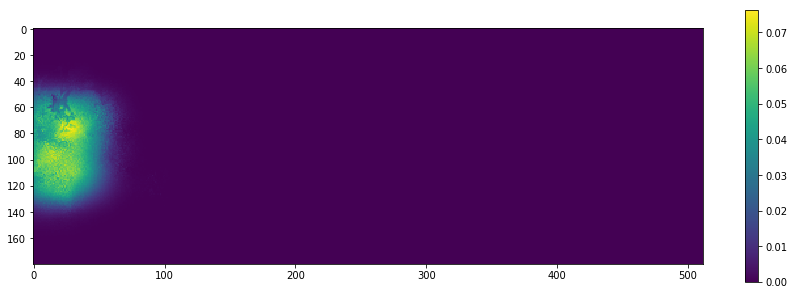

In [198]:
idx = 2
fig, ax = new_fig()
im = ax.imshow(ws_seg.log_omega_mp[idx, :].detach().view(ws_base.width, ws_base.height).exp().cpu().numpy().T)
plt.colorbar(im)

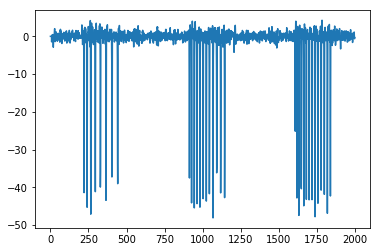

In [199]:
ax = plt.gca()
ax.plot(tau_mt[idx, :])

(0, 500)

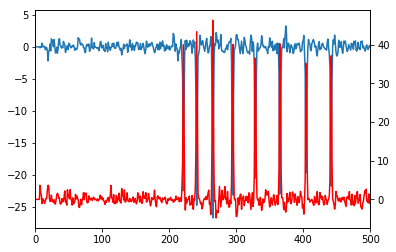

In [200]:
ax = plt.gca()
ax.plot(tau_mt[0, :])
ax2 = ax.twinx()
ax2.plot(tau_mt[1, :], color='red')
ax.set_xlim((0, 500))

## Exploration